# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre un usuario y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

En el siguiente repositorio se pueden encontrar tanto este Notebook como los archivos generados durante el mismo <br> https://github.com/SebaCampa/DS_Acamica_Publico.git

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install surprise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

from sklearn.preprocessing import MinMaxScaler

import gc #garbage collector

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
#from surprise import KNNBasic
from surprise import BaselineOnly
#from surprise import NormalPredictor

from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection.validation import cross_validate

In [ ]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

############################################################################################################

### Sistema de Ponderación para obtener Calificación de un Juego (por usuario)

El sistema de puntos que utilizaré para obtener una calificación será de 1 a 5 puntos, teniendo en cuenta la siguiente ponderación por cada característica:

* Games.Gratis si/no ........................................................... 10%
* Games.Sentiment ............................................................. 30%
* Reviews.Acumulado hs de juego (popularidad) ............. 10%
* Reviews.Horas jugadas .................................................... 50%





- Games.Gratis: si=1 / no=5
- Reviews.Acumulado hs de juego (popularidad) : horas totales jugadas por todos los jugadores al juego en cuestión

############################################################################################################

##### Definición de Funciones

Generamos una función para poblar la columna *user_id* con un valor único. Para esto, consideramos que un usuario es distinto de otro teniendo en cuenta las coulmnas *user_name* y *products*, ya que en la plataforma existen usuarios diferentes con el mismo *user_name* (ver ejemplo en el archivo "steam_repeated_username.png" ubicado en el repositorio)

In [ ]:
def calculateUserId(u_name,num_products=1):
    #result = 0
    #for i in range(0, len(u_name)) :
    #    result = result + pow(ord(u_name[i]),i+1)
    #result = int(result * len(u_name) * num_products)
    #result = str(result)[0:16]
    #result = str(result)
    result = u_name + str(num_products)
    result = int.from_bytes(hashlib.sha256(bytes(str(result), encoding='utf-8')).digest()[:4], 'little') # 32-bit

    return result    

In [ ]:
def calculateRating(price, sentiment, popularity, played_hours):
    rating = round(price*0.1 + sentiment*0.3 + popularity*0.1 + played_hours*0.5)
    return rating

In [ ]:
def customScalerHours(hours):
    if 0 < hours < 0.5 :
        hours_scaled=1
    elif 0.5 < hours <= 1.5 :   
        hours_scaled=2
    elif 1.5 < hours <= 8 :
        hours_scaled=3
    elif 8 < hours <= 20 :     
        hours_scaled=4
    else :
        hours_scaled=5
    return hours_scaled    

## **Reviews**

In [ ]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 1
for l in parse('/content/gdrive/MyDrive/Colab Notebooks/datasets/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [ ]:
data_reviews = pd.DataFrame(data_reviews)

In [ ]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


Cambio el tipo de dato de la columna *products* para ahorrar memoria

In [ ]:
data_reviews['products'] = pd.to_numeric(data_reviews.products, downcast="unsigned")

In [ ]:
data_reviews.shape

(7793069, 12)

Analizamos valores nulos

In [ ]:
data_reviews.isna().sum()

username              0
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

In [ ]:
data_reviews.isna().sum() / data_reviews.shape[0]*100

username         0.000000
hours            0.340521
products         0.191978
product_id       0.000000
page_order       0.000000
date             0.000000
text             0.000000
early_access     0.000000
page             0.000000
found_funny     84.592001
compensation    98.131378
user_id         59.242976
dtype: float64

In [ ]:
data_reviews.columns

Index(['username', 'hours', 'products', 'product_id', 'page_order', 'date',
       'text', 'early_access', 'page', 'found_funny', 'compensation',
       'user_id'],
      dtype='object')

Haciendo una exploración directamente en la plataforma *Steam*, siendo usuario, encuentro las siguientes columnas como irrelevantes para nuestro análisis:

* *page_order*: posición de la reseña en la página
* *page*: número de página donde se encuentra la reseña
* *date*: fecha en que fue escrita la review
* *compensation*: indica si el juego fue comprado o regalado
* *found_funny*: indica si la reseña resultó graciosa para otros usuarios que la leyeron
* *early_access*: indica si el juego está en fase Alfa o Beta (True), o si está en estado final

Dicho esto, elimino las columnas mencionadas 

In [ ]:
data_reviews = data_reviews.drop(["page_order", "page", "date", "compensation", "found_funny", "early_access"], axis=1)

Un dato MUY importante que falta en el dataset es la calificación del usuario hacia el juego del que está escribiendo la reseña (*Positiva* o *Negativa*, tal como califica *Steam*). Una forma interesante de deducirla sería realizar un modelo de *Procesamiento de Lenguaje Natural* sobre el campo *text*, que contiene la reseña propiamente dicha. La desventaja que conlleva esta aproximación es que se trata de un proyecto en sí mismo, con lo cual escapa al alcance del proyecto actual. 

Mencionado el párrafo anterior, descarto también la columna *text*

In [ ]:
data_reviews = data_reviews.drop('text', axis=1)

In [ ]:
data_reviews.head()

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
4,DarklyThinking,16.6,577.0,35140,76561198007483075


In [ ]:
gc.collect()

176

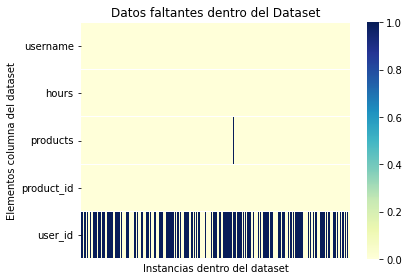

In [ ]:
# Muevo el Heatmap de datos faltantes a una celda posterior a la eliminación de columnas, para ahorrar memoria
dat = data_reviews.isnull()
heat = sns.heatmap(dat.T, cmap="YlGnBu", xticklabels=False)
plt.title("Datos faltantes dentro del Dataset")
plt.xlabel("Instancias dentro del dataset")
plt.ylabel("Elementos columna del dataset")
plt.tight_layout()

La columna *user_id* es sumamente útil, pero tiene el 59% de datos faltantes. El problema que tiene la columna *username* para ser utilizada como clave primaria es que existen usuarios diferentes con el mismo valor en este campo.

Cuento la cantidad de filas con *user_id* faltante, para luego ver cuál es la proporción de usuarios no repetidos (con una sola review) sin valor en dicho campo

In [ ]:
userId_missing = data_reviews[data_reviews.user_id.isna()]

In [ ]:
userId_missing.head()

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,NaN
2,hello?<,14.6,2.0,328100,NaN
3,Cyderine916,5.0,64.0,35140,NaN
5,Teef 🐏,0.9,923.0,725280,NaN


In [ ]:
userId_missing.shape

(4616846, 5)

In [ ]:
username_grouped_missingId = userId_missing.groupby('username').count().reset_index()
username_grouped_missingId = username_grouped_missingId[['username','product_id']]
username_grouped_missingId.rename(columns={'product_id': 'quantity'}, inplace=True)
username_grouped_missingId.head()

,username,quantity
0,!,2
1,! !,6
2,! *,6
3,! SLIDE0UT_,1
4,! Tiggernymph !,3


In [ ]:
username_grouped_missingId.shape[0]

1341588

1.341.588 registros con *user_id* incompleto, sobre usuarios con una sola review => user_id irrecuperable

In [ ]:
username_grouped_missingId[username_grouped_missingId.quantity == 1].shape[0] / data_reviews['user_id'].isna().sum()*100

14.06509985388293

El 14% de los faltantes corresponden a usuarios no repetidos; por lo tanto, son valores irrecuperables. (con el dataset de Reviews reducido inicial, el valor era del 51%)

Descarto las filas con *products* nulo para poder aplicar la función de generación de *user_id*

In [ ]:
data_reviews = data_reviews[data_reviews.products.notna()]

In [ ]:
## Prueba de la función:
calculateUserId('! adamsmeat.gm ♥',40)

2541321278

Aplicamos la función para poblar la columna *user_id*. Luego testeamos el resultado.

In [ ]:
data_reviews['user_id'] = data_reviews.apply(lambda row: (calculateUserId(row['username'],row['products'])
                                                           ),axis=1)

In [ ]:
data_reviews.head()

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,2368950420
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,2195386568
2,hello?<,14.6,2.0,328100,4109549743
3,Cyderine916,5.0,64.0,35140,2828349764
4,DarklyThinking,16.6,577.0,35140,1578188061


In [ ]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7778108 entries, 0 to 7793068
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   username    object 
 1   hours       float64
 2   products    float64
 3   product_id  object 
 4   user_id     int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 356.1+ MB


La función que utilizamos para generar los IDs de usuarios devuelve enteros sin signo en 32 bits. Modificamos el tipo de dato de la columna *user_id* para ahorrar memoria

In [ ]:
data_reviews['user_id'] = pd.to_numeric(data_reviews.user_id, downcast="unsigned")

Comprobamos que no haya filas con user_id nulo:

In [ ]:
data_reviews.user_id.isna().sum()

0

Realizo una búsqueda de repetidos en el dataset, considerando *iguales* dos registros que tengan mismos *username* y *products*.

In [ ]:
users = data_reviews.groupby(['username','products']).count().reset_index()
users = users[['username','products','product_id']]
users.rename(columns={'product_id': 'quantity_reviews'}, inplace=True)
users.head(20)

,username,products,quantity_reviews
0,!,1.0,1
1,!,21.0,4
2,!,35.0,1
3,!,46.0,1
4,! !,326.0,6
5,! *,165.0,6
6,! SLIDE0UT_,3.0,1
7,! AbuAbdalla,11.0,2
8,! Tiggernymph !,159.0,3
9,! ZerZ,218.0,6


In [ ]:
users.shape

(3030116, 3)

Si en la columna *username* del objeto *users* hay elementos repetidos, se trata de usuarios diferentes con el mismo nombre. Los cuento:

In [ ]:
usernames_repetidos = users.groupby('username').count().reset_index()
usernames_repetidos = users[['username','quantity_reviews']]
#usernames_repetidos.rename(columns={'quantity_reviews': 'quantity'}, inplace=True)
usernames_repetidos.shape[0]

3030116

##### Tratamiento de valores faltantes

Cuento la cantidad de *NaN* en la columna *hours*, que es la que quedó con valores faltantes:

In [ ]:
data_reviews.isna().sum()

username          0
hours         26498
products          0
product_id        0
user_id           0
dtype: int64

In [ ]:
data_reviews.isna().sum() / data_reviews.shape[0]*100

username      0.000000
hours         0.340674
products      0.000000
product_id    0.000000
user_id       0.000000
dtype: float64

Descarto las filas con nulos, ya que en proporción son muy pocas

In [ ]:
data_reviews = data_reviews[data_reviews.hours.notna()]

In [ ]:
data_reviews.shape

(7751610, 5)

In [ ]:
data_reviews.reset_index(inplace=True, drop=True)

Mostramos cómo quedó el dataset de **Reviews** final:

In [ ]:
data_reviews.head()

,username,hours,products,product_id,user_id
0,Chaos Syren,0.1,41.0,725280,2368950420
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,2195386568
2,hello?<,14.6,2.0,328100,4109549743
3,Cyderine916,5.0,64.0,35140,2828349764
4,DarklyThinking,16.6,577.0,35140,1578188061


In [ ]:
gc.collect()  #Liberamos memoria

307

## **Games**

In [ ]:
data_games = []
for l in parse('/content/gdrive/MyDrive/Colab Notebooks/datasets/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [ ]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [ ]:
data_games.shape

(32135, 16)

Vemos cuántos juegos tienen *sentiment* Positivo

In [ ]:
data_games[data_games.sentiment=="Positive"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
83,Telltale Games,"[Action, Adventure]",Sam & Max 102: Situation: Comedy,Sam &amp; Max 102: Situation: Comedy,http://store.steampowered.com/app/8210/Sam__Ma...,2006-12-20,"[Adventure, Action]",NaN,http://steamcommunity.com/app/8210/reviews/?br...,[Single-player],19.99,False,8210,Telltale Games,Positive,NaN
125,Nunchuck Games,"[Casual, Indie]",Ninja Reflex: Steamworks Edition,Ninja Reflex: Steamworks Edition,http://store.steampowered.com/app/13000/Ninja_...,2008-03-21,"[Indie, Casual, Ninja]",NaN,http://steamcommunity.com/app/13000/reviews/?b...,"[Single-player, Multi-player, Steam Achievements]",4.99,False,13000,Sanzaru Games,Positive,57
131,Last Day of Work,"[Casual, Simulation]",Virtual Villagers - The Secret City,Virtual Villagers - The Secret City,http://store.steampowered.com/app/16180/Virtua...,2008-05-28,"[Casual, Simulation]",NaN,http://steamcommunity.com/app/16180/reviews/?b...,[Single-player],9.99,False,16180,Last Day of Work,Positive,NaN
136,MumboJumbo,[Casual],7 Wonders II,7 Wonders II,http://store.steampowered.com/app/15900/7_Wond...,2008-06-10,"[Casual, Puzzle, Match 3, Singleplayer]",NaN,http://steamcommunity.com/app/15900/reviews/?b...,[Single-player],9.99,False,15900,MumboJumbo,Positive,NaN
138,MumboJumbo,[Casual],Luxor 3,Luxor 3,http://store.steampowered.com/app/15930/Luxor_3/,2007-11-13,"[Casual, Puzzle]",NaN,http://steamcommunity.com/app/15930/reviews/?b...,[Single-player],9.99,False,15930,MumboJumbo,Positive,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32045,"PopCap Games, Inc.",[Casual],Hammer Heads Deluxe,Hammer Heads Deluxe,http://store.steampowered.com/app/3400/Hammer_...,2006-08-30,[Casual],NaN,http://steamcommunity.com/app/3400/reviews/?br...,[Single-player],4.99,False,3400,"PopCap Games, Inc.",Positive,NaN
32046,"PopCap Games, Inc.",[Casual],AstroPop Deluxe,AstroPop Deluxe,http://store.steampowered.com/app/3340/AstroPo...,2006-08-30,"[Casual, Puzzle]",NaN,http://steamcommunity.com/app/3340/reviews/?br...,[Single-player],4.99,False,3340,"PopCap Games, Inc.",Positive,NaN
32047,"PopCap Games, Inc.",[Casual],Big Money! Deluxe,Big Money! Deluxe,http://store.steampowered.com/app/3360/Big_Mon...,2006-08-30,[Casual],NaN,http://steamcommunity.com/app/3360/reviews/?br...,[Single-player],4.99,False,3360,"PopCap Games, Inc.",Positive,NaN
32115,Spiderweb Software,"[Strategy, RPG, Indie]",Geneforge 2,Geneforge 2,http://store.steampowered.com/app/200980/Genef...,2003-07-01,"[RPG, Indie, Strategy, Turn-Based Combat, Isom...",NaN,http://steamcommunity.com/app/200980/reviews/?...,[Single-player],19.99,False,200980,Spiderweb Software,Positive,NaN


In [ ]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

Revisamos los faltantes como porcentajes del dataset:

In [ ]:
data_games.isna().sum() / data_games.shape[0]*100

publisher         25.056792
genres            10.216275
app_name           0.006224
title              6.379337
url                0.000000
release_date       6.432239
tags               0.507235
discount_price    99.299829
reviews_url        0.006224
specs              2.084954
price              4.285047
early_access       0.000000
id                 0.006224
developer         10.266065
sentiment         22.349463
metascore         91.669519
dtype: float64

In [ ]:
data_games.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'discount_price', 'reviews_url', 'specs', 'price',
       'early_access', 'id', 'developer', 'sentiment', 'metascore'],
      dtype='object')

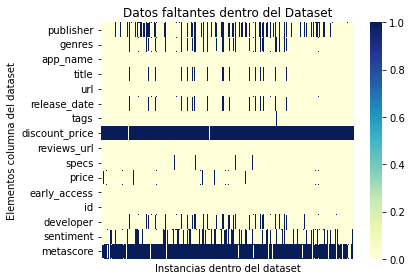

In [ ]:
dat = data_games.isnull()
heat = sns.heatmap(dat.T, cmap="YlGnBu", xticklabels=False)
plt.title("Datos faltantes dentro del Dataset")
plt.xlabel("Instancias dentro del dataset")
plt.ylabel("Elementos columna del dataset")
plt.tight_layout()

En el caso del dataset de Juegos, considero irrelevantes las siguientes columnas:

* *title*: contiene la misma información que la columna *app_name* pero con muchos datos faltantes
* *url*: el link al juego en la tienda
* *discount_price*: extremadamente populado con datos faltantes
* *reviews_url*: el link a las reviews del juego en la tienda
* *release_date*: fecha de lanzamiento del juego. No la tengo en cuenta en mi sistema de ponderación y tiene faltantes

Por otro lado, nuestro *Sistema de Recomendación* será basado en un *Filtro Colaborativo*. Esto significa que los ítems (juegos) serán recomendados según un índice de similitud o cercanía entre usuarios, y no según su categoría, etiquetas, editor, y demás características propias del juego. 
Dicho esto, puedo descartar las siguientes columnas:

* *publisher*: editor del juego
* *genres*: género
* *tags*: etiquetas
* *specs*: SP, MP, Masivo, etc.
* *developer*: desarrollador

La columna *metascore* podría ser altamente útil para ponderar un juego, ya que da un índice de 0 a 100 de su puntuación. Como se observa, el 91% de la información de esta columna es faltante, y ademas es extraída de un sitio externo a nuestra plataforma (www.metacritic.com ). 

In [ ]:
data_games = data_games.drop(["title", "url", "discount_price", "reviews_url", "release_date", "metascore"], axis=1)

In [ ]:
data_games = data_games.drop(["publisher", "genres", "tags", "specs", "developer"], axis=1)

In [ ]:
data_games.head()

,app_name,price,early_access,id,sentiment
0,Lost Summoner Kitty,4.99,False,761140,NaN
1,Ironbound,Free To Play,False,643980,Mostly Positive
2,Real Pool 3D - Poolians,Free to Play,False,670290,Mostly Positive
3,弹炸人2222,0.99,False,767400,NaN
4,Log Challenge,2.99,False,773570,NaN


Armo un array con los diferentes valores de *Sentiment* para luego normalizar dicha columna:

In [ ]:
array_sentiment = data_games.groupby('sentiment').count().reset_index()

In [ ]:
array_sentiment = array_sentiment[['sentiment', 'early_access']]
array_sentiment.rename(columns={'early_access':'quantity'}, inplace=True)

In [ ]:
array_sentiment

,sentiment,quantity
0,1 user reviews,2496
1,2 user reviews,1756
2,3 user reviews,1231
3,4 user reviews,964
4,5 user reviews,846
5,6 user reviews,756
6,7 user reviews,619
7,8 user reviews,537
8,9 user reviews,488
9,Mixed,4103


Los primeros 9 elementos literalmente indican el número de usuarios que escribieron una review sobre ese juego. Creo una categoría nueva llamada *Unranked* para agrupar estos elementos, más aquellos juegos que tienen valor de *sentiment* nulo.

In [ ]:
data_games.loc[(data_games.sentiment.isna()),["sentiment"]] = "Unranked"

In [ ]:
data_games.loc[(data_games.sentiment.str.contains('user review')), ["sentiment"]] = "Unranked"

In [ ]:
df_sentiment = data_games.groupby('sentiment').count().reset_index()

In [ ]:
df_sentiment = df_sentiment[['sentiment', 'early_access']]
df_sentiment.rename(columns={'early_access':'quantity'}, inplace=True)

In [ ]:
df_sentiment

,sentiment,quantity
0,Mixed,4103
1,Mostly Negative,802
2,Mostly Positive,2744
3,Negative,123
4,Overwhelmingly Negative,7
5,Overwhelmingly Positive,303
6,Positive,3281
7,Unranked,16875
8,Very Negative,29
9,Very Positive,3868


Agrego una columna numérica con pesos al Dataframe de *Sentiment*

In [ ]:
df_sentiment.loc[:,"weight"] = ""

In [ ]:
df_sentiment.loc[(df_sentiment.sentiment == "Overwhelmingly Negative"), ["weight"]] = 0
df_sentiment.loc[(df_sentiment.sentiment == "Very Negative"), ["weight"]] = 0.5
df_sentiment.loc[(df_sentiment.sentiment == "Negative"), ["weight"]] = 1
df_sentiment.loc[(df_sentiment.sentiment == "Mostly Negative"), ["weight"]] = 1.5
df_sentiment.loc[(df_sentiment.sentiment == "Unranked"), ["weight"]] = 2
df_sentiment.loc[(df_sentiment.sentiment == "Mixed"), ["weight"]] = 2.5
df_sentiment.loc[(df_sentiment.sentiment == "Mostly Positive"), ["weight"]] = 3.5
df_sentiment.loc[(df_sentiment.sentiment == "Positive"), ["weight"]] = 4
df_sentiment.loc[(df_sentiment.sentiment == "Very Positive"), ["weight"]] = 4.5
df_sentiment.loc[(df_sentiment.sentiment == "Overwhelmingly Positive"), ["weight"]] = 5

In [ ]:
df_sentiment

,sentiment,quantity,weight
0,Mixed,4103,2.5
1,Mostly Negative,802,1.5
2,Mostly Positive,2744,3.5
3,Negative,123,1
4,Overwhelmingly Negative,7,0
5,Overwhelmingly Positive,303,5
6,Positive,3281,4
7,Unranked,16875,2
8,Very Negative,29,0.5
9,Very Positive,3868,4.5


In [ ]:
df_sentiment.dtypes

sentiment    object
quantity      int64
weight       object
dtype: object

In [ ]:
#La columna weight se creó con tipo de dato Object. Lo convertimos a float para usarlo en cálculos futuros
df_sentiment['weight'] = pd.to_numeric(df_sentiment['weight'], downcast="float")

Vemos los nulos despues de la eliminación de las columnas:

In [ ]:
data_games.isna().sum() / data_games.shape[0]*100

app_name        0.006224
price           4.285047
early_access    0.000000
id              0.006224
sentiment       0.000000
dtype: float64

Elimino las filas con *id* nulo, ya que no será posible recomendarlos:

In [ ]:
data_games = data_games[data_games.id.notna()]

Haciendo una exploración un poco más avanzada debido a un comportamiento extraño al momento de realizar un merge (o join) entre ambos datasets, descubrí que una fila en el dataset de *games* estaba duplicada en el campo *id*. Esto es un error que la fuente de datos no nos debería enviar.

In [ ]:
data_games_AUX = data_games.groupby('id').count().reset_index()

In [ ]:
data_games_AUX[data_games_AUX['price']>1]

,id,app_name,price,early_access,sentiment
24604,612880,2,2,2,2


Agrego la eliminación de dichos duplicados

In [ ]:
data_games.drop_duplicates(subset=['id'])

,app_name,price,early_access,id,sentiment
0,Lost Summoner Kitty,4.99,False,761140,Unranked
1,Ironbound,Free To Play,False,643980,Mostly Positive
2,Real Pool 3D - Poolians,Free to Play,False,670290,Mostly Positive
3,弹炸人2222,0.99,False,767400,Unranked
4,Log Challenge,2.99,False,773570,Unranked
...,...,...,...,...,...
32130,Colony On Mars,1.99,False,773640,Unranked
32131,LOGistICAL: South Africa,4.99,False,733530,Unranked
32132,Russian Roads,1.99,False,610660,Unranked
32133,EXIT 2 - Directions,4.99,False,658870,Unranked


### Preparo la información necesaria para poder obtener las calificaciones

#### Dataset de Reviews

In [ ]:
# A partir del dataset de Reviews armo un dataframe cone el acumulado de horas jugadas a cada juego 
total_played_hoursXgame = data_reviews.groupby(['product_id']).agg({'hours': ['sum']}).reset_index()
total_played_hoursXgame.columns = ['product_id','sum_hours']

In [ ]:
total_played_hoursXgame.shape

(15386, 2)

In [ ]:
total_played_hoursXgame.head()

,product_id,sum_hours
0,10,97553.9
1,1002,190.9
2,100400,8106.0
3,10090,225714.4
4,100980,6772.4


#### Dataset de Games

Genero una nueva columna para codificar la variable precio, y elimino la columna original que contendrá valores nulos. Los juegos cuyo precio sea nulo son considerados como no gratuitos

In [ ]:
#data_games.loc[:,"price_free"] = ""
data_games.loc[:,'price_free'] = np.where(data_games['price'] == 'Free to Play', np.int8(1), np.int8(5))
data_games = data_games.drop(['price'], axis=1)

Agrego al dataframe de juegos (*data_games*) la columna *sentiment* codificada, y elimino la original

In [ ]:
data_games = data_games.join(df_sentiment.set_index('sentiment')['weight'], on='sentiment', how='left')
data_games.rename(columns={'weight':'enc_sentiment'}, inplace=True)
data_games = data_games.drop(['sentiment'], axis=1)

In [ ]:
data_games.shape

(32133, 5)

In [ ]:
data_games

,app_name,early_access,id,price_free,enc_sentiment
0,Lost Summoner Kitty,False,761140,5,2.0
1,Ironbound,False,643980,5,3.5
2,Real Pool 3D - Poolians,False,670290,1,3.5
3,弹炸人2222,False,767400,5,2.0
4,Log Challenge,False,773570,5,2.0
...,...,...,...,...,...
32130,Colony On Mars,False,773640,5,2.0
32131,LOGistICAL: South Africa,False,733530,5,2.0
32132,Russian Roads,False,610660,5,2.0
32133,EXIT 2 - Directions,False,658870,5,2.0


Obtengo y agrego al dataframe de juegos (data_games) la cantidad de horas totales jugadas a cada uno

In [ ]:
data_games = pd.merge(data_games, total_played_hoursXgame, left_on='id', right_on='product_id', how='left')

In [ ]:
data_games = data_games.drop(['product_id'], axis=1)

In [ ]:
data_games

,app_name,early_access,id,price_free,enc_sentiment,sum_hours
0,Lost Summoner Kitty,False,761140,5,2.0,NaN
1,Ironbound,False,643980,5,3.5,1557.3
2,Real Pool 3D - Poolians,False,670290,1,3.5,39.8
3,弹炸人2222,False,767400,5,2.0,1.6
4,Log Challenge,False,773570,5,2.0,NaN
...,...,...,...,...,...,...
32128,Colony On Mars,False,773640,5,2.0,NaN
32129,LOGistICAL: South Africa,False,733530,5,2.0,NaN
32130,Russian Roads,False,610660,5,2.0,0.4
32131,EXIT 2 - Directions,False,658870,5,2.0,28.9


In [ ]:
data_games.dtypes

app_name          object
early_access        bool
id                object
price_free          int8
enc_sentiment    float32
sum_hours        float64
dtype: object

Los valores NaN en la columna *sum_hours* indican que dicho juego no tiene reviews, y por lo tanto no tiene cantidad de horas jugadas. Dicho esto, reemplazo los NaN por 0

In [ ]:
data_games['sum_hours'] = np.where(data_games['sum_hours'].isna(), 0, data_games['sum_hours'])

In [ ]:
data_games

,app_name,early_access,id,price_free,enc_sentiment,sum_hours
0,Lost Summoner Kitty,False,761140,5,2.0,0.0
1,Ironbound,False,643980,5,3.5,1557.3
2,Real Pool 3D - Poolians,False,670290,1,3.5,39.8
3,弹炸人2222,False,767400,5,2.0,1.6
4,Log Challenge,False,773570,5,2.0,0.0
...,...,...,...,...,...,...
32128,Colony On Mars,False,773640,5,2.0,0.0
32129,LOGistICAL: South Africa,False,733530,5,2.0,0.0
32130,Russian Roads,False,610660,5,2.0,0.4
32131,EXIT 2 - Directions,False,658870,5,2.0,28.9


In [ ]:
data_games.reset_index(inplace=True, drop=True)

Guardo el dataset de *Games* modificado y con menos columnas para usarlo más adelante durante las recomendaciones

In [ ]:
data_games_light = data_games.copy()
data_games_light.drop(columns={'early_access','price_free','enc_sentiment','sum_hours'}, inplace=True)

In [ ]:
data_games_light.to_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/proyecto3_data_games_light.csv', index= False)

In [ ]:
gc.collect()

134

### Armo un dataframe con toda la información

In [ ]:
#df_reviewsxgame = data_reviews.join(data_games.set_index('id'), on='product_id', how='left')

In [ ]:
df_reviewsxgame = pd.merge(data_reviews, data_games, left_on='product_id', right_on='id', how='left')

In [ ]:
data_reviews.shape

(7751610, 5)

In [ ]:
df_reviewsxgame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7758078 entries, 0 to 7758077
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   username       object 
 1   hours          float64
 2   products       float64
 3   product_id     object 
 4   user_id        uint32 
 5   app_name       object 
 6   early_access   bool   
 7   id             object 
 8   price_free     int8   
 9   enc_sentiment  float32
 10  sum_hours      float64
dtypes: bool(1), float32(1), float64(3), int8(1), object(4), uint32(1)
memory usage: 547.5+ MB


In [ ]:
df_reviewsxgame

,username,hours,products,product_id,user_id,app_name,early_access,id,price_free,enc_sentiment,sum_hours
0,Chaos Syren,0.1,41.0,725280,2368950420,Psi Project,False,725280,5,4.0,3.000000e+00
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,2195386568,Gunspell - Steam Edition,False,328100,5,2.5,7.765000e+02
2,hello?<,14.6,2.0,328100,4109549743,Gunspell - Steam Edition,False,328100,5,2.5,7.765000e+02
3,Cyderine916,5.0,64.0,35140,2828349764,Batman: Arkham Asylum Game of the Year Edition,False,35140,5,5.0,1.956344e+05
4,DarklyThinking,16.6,577.0,35140,1578188061,Batman: Arkham Asylum Game of the Year Edition,False,35140,5,5.0,1.956344e+05
...,...,...,...,...,...,...,...,...,...,...,...
7758073,Wildman_,174.3,208.0,252490,821245193,Rust,True,252490,5,4.5,4.410981e+07
7758074,Stony,1215.2,73.0,252490,2794114267,Rust,True,252490,5,4.5,4.410981e+07
7758075,Deez Knees,50.5,288.0,252490,613956298,Rust,True,252490,5,4.5,4.410981e+07
7758076,Vidaar,783.5,353.0,252490,1938294537,Rust,True,252490,5,4.5,4.410981e+07


##### Cuento la cantidad de nulos en el nuevo dataframe

In [ ]:
df_reviewsxgame.isna().sum() / df_reviewsxgame.shape[0]*100

username         0.0
hours            0.0
products         0.0
product_id       0.0
user_id          0.0
app_name         0.0
early_access     0.0
id               0.0
price_free       0.0
enc_sentiment    0.0
sum_hours        0.0
dtype: float64

#### Con la información disponible al momento, podemos responder las siguientes preguntas

##### ¿Cuáles son los juegos con mayor cantidad de reviews?

In [ ]:
most_reviewed_games = df_reviewsxgame.groupby(['product_id','app_name']).count().reset_index()
most_reviewed_games = most_reviewed_games[['product_id','app_name','username']]
most_reviewed_games.rename(columns={'username': 'quantity'}, inplace=True)
most_reviewed_games = most_reviewed_games.sort_values(by='quantity',ascending=False)
most_reviewed_games.head(20)

,product_id,app_name,quantity
7798,440,Team Fortress 2,182360
1338,252490,Rust,102150
9327,49520,Borderlands 2,72699
5524,377160,Fallout 4,70774
1841,271590,Grand Theft Auto V,59067
6104,391540,Undertale,57582
12403,620,Portal 2,56016
708,221100,DayZ,54874
868,230410,Warframe,53747
2649,301520,Robocraft,51728


##### ¿Cuáles son los juegos más jugados? (mayor cantidad de horas de juego acumuladas - popularidad)

In [ ]:
most_played_games = df_reviewsxgame.groupby(['product_id','app_name']).agg({'hours': ['sum']}).reset_index()

In [ ]:
most_played_games.columns = ['product_id','app_name','sum_hours']
#most_played_games = most_played_games.sort_values(by='sum_hours',ascending=False)
#most_played_games.head(20)
most_played_games.sort_values(by='sum_hours',ascending=False).head(20)

,product_id,app_name,sum_hours
7798,440,Team Fortress 2,1.345468e+08
1338,252490,Rust,4.410981e+07
868,230410,Warframe,3.290734e+07
6425,4000,Garry's Mod,2.677348e+07
47,107410,Arma 3,2.546899e+07
4225,346110,ARK: Survival Evolved,2.235645e+07
5524,377160,Fallout 4,1.595504e+07
9103,48700,Mount & Blade: Warband,1.468083e+07
1050,240,Counter-Strike: Source,1.349106e+07
708,221100,DayZ,1.312318e+07


##### ¿Cuántos jugadores diferentes tenemos?

In [ ]:
total_players = df_reviewsxgame.groupby(['user_id']).agg({'user_id': ['count']}).reset_index()
total_players.columns = ['user_id', 'quantity_reviews']

In [ ]:
total_players.shape[0]

3023765

##### Información disponible de un usuario en particular

In [ ]:
df_reviewsxgame[df_reviewsxgame.user_id==3621156896]

,username,hours,products,product_id,user_id,app_name,early_access,id,price_free,enc_sentiment,sum_hours
18379,Cracktus Jack,1.4,318.0,341720,3621156896,Among Ripples,False,341720,5,3.5,1262.7
25657,Cracktus Jack,107.5,318.0,1610,3621156896,Space Empires IV Deluxe,False,1610,5,4.5,9405.5
255970,Cracktus Jack,4.2,318.0,414660,3621156896,Vampire Legends: The True Story of Kisilova,False,414660,5,4.5,506.6
817740,Cracktus Jack,18.2,318.0,348360,3621156896,Doodle God,False,348360,5,3.5,3945.6
823536,Cracktus Jack,20.5,318.0,261940,3621156896,The Mysterious Cities of Gold,False,261940,5,3.5,237.8
...,...,...,...,...,...,...,...,...,...,...,...
6811450,Cracktus Jack,2.7,318.0,288160,3621156896,The Room,False,288160,5,5.0,18965.9
7180657,Cracktus Jack,10.6,318.0,39630,3621156896,AquaNox,False,39630,5,3.5,704.9
7218942,Cracktus Jack,5.9,318.0,391340,3621156896,Ferrum's Secrets: Where Is Grandpa?,False,391340,5,2.5,192.5
7498755,Cracktus Jack,83.0,318.0,234140,3621156896,Mad Max,False,234140,5,4.5,759855.1


In [ ]:
gc.collect()

100

##### ¿Cuántas reviews hizo cada uno de los jugadores?

In [ ]:
total_players

,user_id,quantity_reviews
0,6045,6
1,6946,1
2,8121,1
3,10859,2
4,11988,1
...,...,...
3023760,4294961450,1
3023761,4294961831,1
3023762,4294964606,1
3023763,4294965661,1


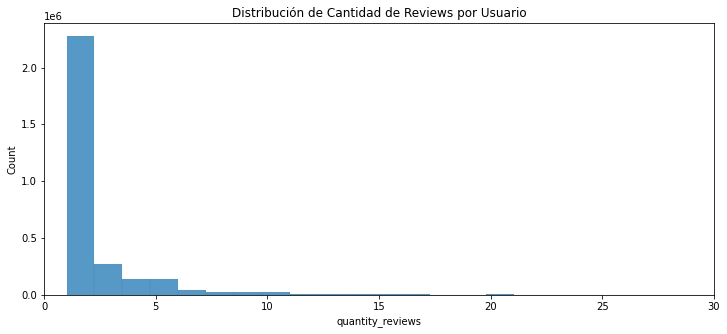

In [ ]:
sns.histplot(data=total_players.quantity_reviews, bins=1000)
plt.title("Distribución de Cantidad de Reviews por Usuario")
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 40, 50])
plt.xlim(right=30) 
plt.xlim(left=0)
plt.gcf().set_size_inches(12, 5)

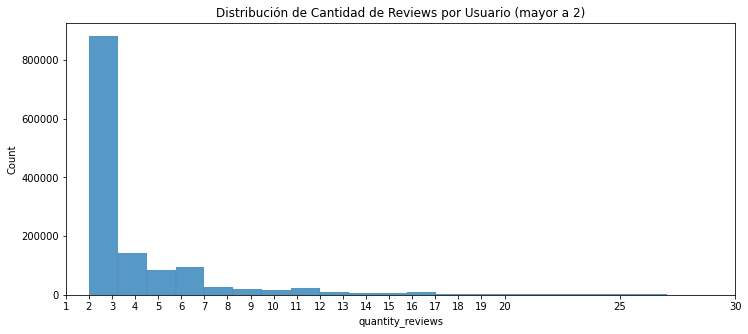

In [ ]:
mask_quantity_reviews = (total_players.quantity_reviews > 1)
sns.histplot(data=total_players[mask_quantity_reviews].quantity_reviews, bins=1000)
plt.title("Distribución de Cantidad de Reviews por Usuario (mayor a 2)")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30])
plt.xlim(right=30) 
plt.xlim(left=1)  
plt.gcf().set_size_inches(12, 5)

### Escalado de datos para obtener las calificaciones

Para obtener una calificación, es necesario que cada una de las partes que la componen se encuentre en la misma escala. Para ello debemos definir un scaler; en nuestro caso optamos por *MinMaxScaler*.

In [ ]:
## Defino un scaler para cada conjunto de variable :
scaler_popularidad = MinMaxScaler(feature_range=(1,5))
scaler_played_time = MinMaxScaler(feature_range=(1,5))

scaler_popularidad.fit(df_reviewsxgame[['sum_hours']])
scaler_played_time.fit(df_reviewsxgame[['hours']]) # Escalado del Tiempo jugado por X jugador a Y juego
array_popularidad_escaladas = scaler_popularidad.transform(df_reviewsxgame[['sum_hours']])
array_played_time_escaladas = scaler_played_time.transform(df_reviewsxgame[['hours']])

In [ ]:
data_reviews.shape

(7751610, 5)

In [ ]:
np.array(array_popularidad_escaladas)
np.array(array_played_time_escaladas)

array([[1.0000095 ],
       [1.00485503],
       [1.00138715],
       ...,
       [1.00479802],
       [1.07444057],
       [1.0950198 ]])

In [ ]:
df_aux_popularidad = pd.DataFrame(array_popularidad_escaladas, columns = ['sum_hours_scaled'])
df_aux_played_time = pd.DataFrame(array_played_time_escaladas, columns = ['hours_scaled'])

Agrego la información escalada al DataFrame general

In [ ]:
df_reviewsxgame = pd.concat([df_reviewsxgame, df_aux_popularidad], axis=1)

In [ ]:
df_reviewsxgame = pd.concat([df_reviewsxgame, df_aux_played_time], axis=1)

In [ ]:
df_reviewsxgame

,username,hours,products,product_id,user_id,app_name,early_access,id,price_free,enc_sentiment,sum_hours,sum_hours_scaled,hours_scaled
0,Chaos Syren,0.1,41.0,725280,2368950420,Psi Project,False,725280,5,4.0,3.000000e+00,1.000000,1.000010
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,2195386568,Gunspell - Steam Edition,False,328100,5,2.5,7.765000e+02,1.000023,1.004855
2,hello?<,14.6,2.0,328100,4109549743,Gunspell - Steam Edition,False,328100,5,2.5,7.765000e+02,1.000023,1.001387
3,Cyderine916,5.0,64.0,35140,2828349764,Batman: Arkham Asylum Game of the Year Edition,False,35140,5,5.0,1.956344e+05,1.005816,1.000475
4,DarklyThinking,16.6,577.0,35140,1578188061,Batman: Arkham Asylum Game of the Year Edition,False,35140,5,5.0,1.956344e+05,1.005816,1.001577
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7758073,Wildman_,174.3,208.0,252490,821245193,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.016560
7758074,Stony,1215.2,73.0,252490,2794114267,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.115457
7758075,Deez Knees,50.5,288.0,252490,613956298,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.004798
7758076,Vidaar,783.5,353.0,252490,1938294537,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.074441


In [ ]:
df_reviewsxgame.dtypes


username             object
hours               float64
products            float64
product_id           object
user_id              uint32
app_name             object
early_access           bool
id                   object
price_free             int8
enc_sentiment       float32
sum_hours           float64
sum_hours_scaled    float64
hours_scaled        float64
dtype: object

##### En este punto, disponemos de un DataFrame con toda la información para calcular la calificación de cada juego según nuestro sistema de puntuación

In [ ]:
df_reviewsxgame.loc[:,'rating'] = df_reviewsxgame.apply(lambda row: (calculateRating(row['price_free'],row['enc_sentiment'],row['sum_hours_scaled'],row['hours_scaled'])
                                                           ),axis=1)

In [ ]:
df_reviewsxgame

,username,hours,products,product_id,user_id,app_name,early_access,id,price_free,enc_sentiment,sum_hours,sum_hours_scaled,hours_scaled,rating
0,Chaos Syren,0.1,41.0,725280,2368950420,Psi Project,False,725280,5,4.0,3.000000e+00,1.000000,1.000010,2
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,2195386568,Gunspell - Steam Edition,False,328100,5,2.5,7.765000e+02,1.000023,1.004855,2
2,hello?<,14.6,2.0,328100,4109549743,Gunspell - Steam Edition,False,328100,5,2.5,7.765000e+02,1.000023,1.001387,2
3,Cyderine916,5.0,64.0,35140,2828349764,Batman: Arkham Asylum Game of the Year Edition,False,35140,5,5.0,1.956344e+05,1.005816,1.000475,3
4,DarklyThinking,16.6,577.0,35140,1578188061,Batman: Arkham Asylum Game of the Year Edition,False,35140,5,5.0,1.956344e+05,1.005816,1.001577,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7758073,Wildman_,174.3,208.0,252490,821245193,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.016560,3
7758074,Stony,1215.2,73.0,252490,2794114267,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.115457,3
7758075,Deez Knees,50.5,288.0,252490,613956298,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.004798,3
7758076,Vidaar,783.5,353.0,252490,1938294537,Rust,True,252490,5,4.5,4.410981e+07,2.311359,1.074441,3


### Matriz de Ratings

Creamos un DataFrame únicamente con la información que necesitamos: *user_id*, *product_id*, *rating*.
Partiendo de la Matriz de Ratings podemos llegar a la **Matriz de Utilidad** si tomamos todos los usuarios y todos los juegos; de esta manera obtendríamos las celdas con rating y las celdas vacías que caracterizan a dicha matriz. 

In [ ]:
df_ratings_matrix = df_reviewsxgame.loc[:, ['user_id', 'product_id', 'rating']]

In [ ]:
#df_ratings_matrix.infer_objects().dtypes
df_ratings_matrix['user_id'] = pd.to_numeric(df_ratings_matrix.user_id, downcast="unsigned")
df_ratings_matrix['product_id'] = pd.to_numeric(df_ratings_matrix.product_id, downcast="integer")
df_ratings_matrix['rating'] = pd.to_numeric(df_ratings_matrix.rating, downcast="integer")

In [ ]:
df_ratings_matrix.head()

,user_id,product_id,rating
0,2368950420,725280,2
1,2195386568,328100,2
2,4109549743,328100,2
3,2828349764,35140,3
4,1578188061,35140,3


In [ ]:
df_ratings_matrix.dtypes

user_id       uint32
product_id     int32
rating          int8
dtype: object

Una información útil en este punto es ver cómo es la distribución de las calificaciones (ratings) generada por nuestro algoritmo

(array([2.469870e+05, 0.000000e+00, 0.000000e+00, 5.828299e+06,
        0.000000e+00, 0.000000e+00, 1.682765e+06, 0.000000e+00,
        0.000000e+00, 2.700000e+01]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

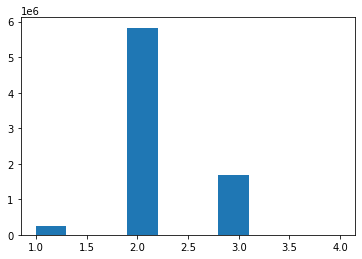

In [ ]:
plt.hist(df_ratings_matrix.rating)

Como se observa en en el gráfico, la distribución de la variable *rating* no tiene el comportamiento esperado. El motivo por el cuál sucede esto viene dado por la variable *hours* del dataset de **Reviws**: al representar en nuestro algoritmo de calificaciones el 50% de la puntuación final, y siendo la distribución de dicha variable completamente distinta a una Normal con máximos de valor en torno a las 5.000 horas de juego para unas pocas filas (ver gráfico siguiente), la gran mayoría de éstas toma valores muy bajos provocando que nuestra calificación final sea también muy baja en el 100% de los casos. Por tal motivo, debemos desestimar el uso de *MinMaxScaler* para la variable *hours*, y realizar un escalado a mano adoptando la siguiente estrategia:<br>
* 0<hours<=0.5 -> hours_scaled=1
* 0.5<hours<=1.5 -> hours_scaled=2
* 1.5<hours<=5 -> hours_scaled=3
* 5<hours<=10 -> hours_scaled=4
* hours>10 -> hours_scaled=5

(array([7.740803e+06, 9.489000e+03, 9.740000e+02, 2.400000e+02,
        6.800000e+01, 2.100000e+01, 1.100000e+01, 3.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([    0.  ,  4210.07,  8420.14, 12630.21, 16840.28, 21050.35,
        25260.42, 29470.49, 33680.56, 37890.63, 42100.7 ]),
 <a list of 10 Patch objects>)

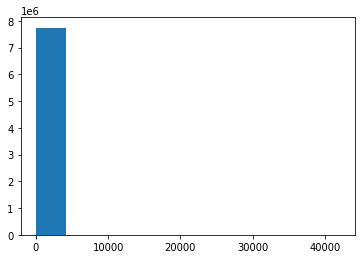

In [ ]:
plt.hist(data_reviews.hours)

Usamos una función lambda para poblar nuevamente la columna *hours_scaled* en df_reviewsxgame

In [ ]:
df_reviewsxgame.loc[:,'hours_scaled'] = df_reviewsxgame.apply(lambda row: (customScalerHours(row['hours'])
                                                           ),axis=1)

(array([ 390293.,       0.,  579488.,       0.,       0., 1800281.,
              0., 1453132.,       0., 3534884.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

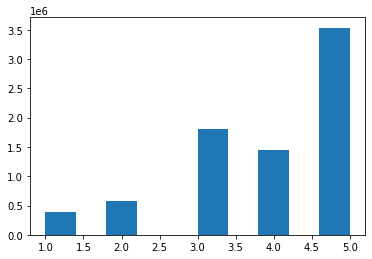

In [ ]:
plt.hist(df_reviewsxgame.hours_scaled)

Calculamos nuevamente los ratings del dataframe df_reviewsxgame

In [ ]:
df_reviewsxgame.loc[:,'rating'] = df_reviewsxgame.apply(lambda row: (calculateRating(row['price_free'],row['enc_sentiment'],row['sum_hours_scaled'],row['hours_scaled'])
                                                           ),axis=1)

Volvemos a generar la **Matriz de Ratings**

In [ ]:
df_ratings_matrix = df_reviewsxgame.loc[:, ['user_id', 'product_id', 'rating']]
df_ratings_matrix['user_id'] = pd.to_numeric(df_ratings_matrix.user_id, downcast="unsigned")
df_ratings_matrix['product_id'] = pd.to_numeric(df_ratings_matrix.product_id, downcast="integer")
df_ratings_matrix['rating'] = pd.to_numeric(df_ratings_matrix.rating, downcast="integer")

In [ ]:
df_ratings_matrix.to_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/proyecto3_matriz_ratings.csv', index= False)

In [ ]:
gc.collect()

0


##################################################################################


## **Modelado y Entrenamiento**

A partir de acá utilizamos el archivo generado, para no tener que pre-procesar nuevamente toda la información previa. Comenzamos con la utilización de la biblioteca **Surprise**, que ofrece herramientas específicas para modelar un sistema de recomendación

In [ ]:
df_ratings_matrix = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/proyecto3_matriz_ratings.csv', dtype={'user_id':np.uint32, 'rating': np.int8, 'product_id': np.int32})
print(df_ratings_matrix.shape)
df_ratings_matrix.head()

(7758078, 3)


,user_id,product_id,rating
0,2368950420,725280,2
1,2195386568,328100,4
2,4109549743,328100,3
3,2828349764,35140,4
4,1578188061,35140,4


In [ ]:
df_ratings_matrix.dtypes

user_id       uint32
product_id     int32
rating          int8
dtype: object

Cargo el dataset de *Games* reducido para tener disponible el *id* de los Juegos y los *titulos*

In [ ]:
df_games_light = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/datasets/proyecto3_data_games_light.csv', dtype={'id': np.int32})

In [ ]:
df_games_light.dtypes

app_name    object
id           int32
dtype: object

Miramos nuevamente cómo es la distribución de las calificaciones

(array([  36166.,       0.,  546006.,       0.,       0., 2186044.,
              0., 4161346.,       0.,  828516.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

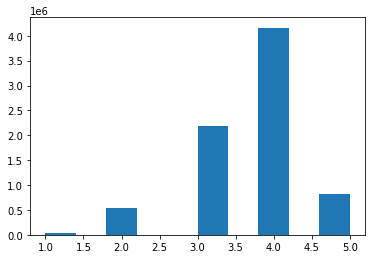

In [ ]:
plt.hist(df_ratings_matrix.rating)

In [ ]:
reader = Reader(rating_scale=(1, 5))

Generamos un dataset con el formato que usa la biblioteca *Surprise* a partir de nuestra matriz de ratings

In [ ]:
data_ratings = Dataset.load_from_df(df_ratings_matrix[['user_id', 'product_id', 'rating']], reader)

### Modelo de Benchmark

Generamos un modelo de Benchmark que utilizaremos para comparar los resultados de nuestro modelo final. En este caso, tomamos *Baseline Only* y aplicamos la función *cross_validate* de *Surprise* que realiza todo en un paso. <br> (Nota: Intenté utilizar *KNN Basic*, que permite por ejemplo setear el algoritmo de cálculo de distancia entre usuarios, pero no pude resolver el error de falta de memoria)

In [ ]:
bsl_benchmark_options = {'method': 'sgd',
               'n_epochs': 20,
               }
#sim_benchmark_options = {'name': 'cosine', 'user_based': True}
#algo_benchmark = KNNBasic(bsl_options=bsl_benchmark_options, sim_options=sim_benchmark_options)

#algo_benchmark = BaselineOnly(bsl_options=bsl_benchmark_options)

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [BaselineOnly(bsl_benchmark_options)]:
    # Perform cross validation
    results = cross_validate(algorithm, data_ratings, measures=['RMSE'], cv=3, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
dfBenchmark = pd.DataFrame(benchmark)     

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


In [ ]:
dfBenchmark

,test_rmse,fit_time,test_time,Algorithm
0,0.508342,90.602211,30.413756,BaselineOnly


In [ ]:
rmse_benchmark = dfBenchmark['test_rmse'][0]

In [ ]:
gc.collect()

331

### Modelo Final

Entrenamos un algoritmo *SVD*

In [ ]:
trainset, testset = train_test_split(data_ratings, test_size=.30)

In [ ]:
algo = SVD()

In [ ]:
algo.fit(trainset)

In [ ]:
gc.collect()

103

Hacemos predicciones sobre el lote de testing

In [ ]:
predictions = algo.test(testset)

Tomamos una predicción al azar

In [ ]:
predictions[11]

Prediction(uid=2757749126, iid=259780, r_ui=3.0, est=3.5195175471646833, details={'was_impossible': False})

In [ ]:
df_ratings_matrix[df_ratings_matrix.user_id==1804600080]

,user_id,product_id,rating
150357,1804600080,230050,3
201341,1804600080,560260,3
282445,1804600080,225080,4
1396214,1804600080,529900,3
1416821,1804600080,37600,3
2378875,1804600080,341730,4
2434487,1804600080,46500,3
2473501,1804600080,447950,3
2635020,1804600080,98100,3
2809744,1804600080,297130,4


Utilizamos RMSE como medida del error de nuestro algoritmo. Tanto MSE como RMSE usan las desviaciones al cuadrado, penalizando así los errores más grandes.

In [ ]:
rmse_svd = accuracy.rmse(predictions)

RMSE: 0.5103


In [ ]:
gc.collect()

3282

#### Optimización de Hyperparámetros

Utilizamos los valores default de referencia

In [ ]:
from surprise.model_selection import RandomizedSearchCV

In [ ]:
param_grid = {'n_epochs': [10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6],
              'n_factors': [2, 10]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = 1)
#gs = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = 1)
gs.fit(data_ratings)

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.5379117766589377
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'n_factors': 2}


Graficamos el error tomando los hyperparámetros óptimos, para los diferentes factores usados

In [ ]:
factores = [2, 10]
rmse_test_means = []
df_cv_results = pd.DataFrame(gs.cv_results)

In [ ]:
mask_best_params = (df_cv_results.param_n_epochs==10) & (df_cv_results.param_lr_all==0.005) & (df_cv_results.param_reg_all==0.4)
rmse_test_means.append(df_cv_results.mean_test_rmse[mask_best_params & (df_cv_results.param_n_factors==2)])
rmse_test_means.append(df_cv_results.mean_test_rmse[mask_best_params & (df_cv_results.param_n_factors==10)])

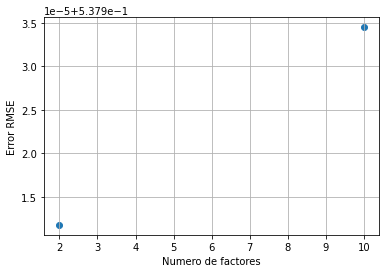

In [ ]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.grid()
plt.show()

#### Vemos qué juegos recomienda el sistema a un usuario tomado al azar

Juegos que calificó entre 4 y 5

In [ ]:
usuario = 1804600080
rating = 4   # Rating entre 4 y 5
df_user = df_ratings_matrix[(df_ratings_matrix['user_id'] == usuario) & (df_ratings_matrix['rating'] >= rating)]
df_user = df_user.reset_index(drop=True)

In [ ]:
df_user.dtypes

user_id       uint32
product_id     int32
rating          int8
dtype: object

In [ ]:
df_user.loc[:,'GameName'] = df_user.apply(lambda row: ( df_games_light[(df_games_light.id==row['product_id'])].app_name.values[0]
                                                           ),axis=1)

In [ ]:
df_user

,user_id,product_id,rating,GameName
0,1804600080,225080,4,Brothers - A Tale of Two Sons
1,1804600080,341730,4,Dustoff Heli Rescue
2,1804600080,297130,4,Titan Souls
3,1804600080,266490,4,Lili: Child of Geos - Complete Edition
4,1804600080,7670,4,BioShock™
5,1804600080,70300,4,VVVVVV
6,1804600080,259810,4,Home Sheep Home 2
7,1804600080,284730,4,Dark Arcana: The Carnival
8,1804600080,259550,4,Hero of the Kingdom
9,1804600080,421040,4,Plantera


Hacemos una copia del Dataframe de *Games*, que usaremos luego para hacer la recomendación

In [ ]:
recomendaciones_usuario = df_games_light.copy()
#recomendaciones_usuario.drop(columns={'early_access','price_free','enc_sentiment','sum_hours'}, inplace=True)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32133, 2)


,app_name,id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570


In [ ]:
recomendaciones_usuario.dtypes

app_name    object
id           int32
dtype: object

Armamos un dataframe con los juegos que el usuario jugó

In [ ]:
usuario_juegos_jugados = df_ratings_matrix[df_ratings_matrix['user_id'] == usuario]
print(usuario_juegos_jugados.shape)
usuario_juegos_jugados.head()

(31, 3)


,user_id,product_id,rating
150357,1804600080,230050,3
201341,1804600080,560260,3
282445,1804600080,225080,4
1396214,1804600080,529900,3
1416821,1804600080,37600,3


In [ ]:
usuario_juegos_jugados.dtypes

user_id       uint32
product_id     int32
rating          int8
dtype: object

Sacamos del dataframe los juegos que el usuario jugó

In [ ]:
# Convierto el product_id a string ya que en el dataframe "recomendaciones_usuario" tiene ese tipo de dato:
for value in usuario_juegos_jugados.product_id:
    recomendaciones_usuario.drop( recomendaciones_usuario[ recomendaciones_usuario['id'] == value ].index , inplace=True)

recomendaciones_usuario.head()

,app_name,id
0,Lost Summoner Kitty,761140
1,Ironbound,643980
2,Real Pool 3D - Poolians,670290
3,弹炸人2222,767400
4,Log Challenge,773570


In [ ]:
recomendaciones_usuario.shape

(32103, 2)

Hacemos recomendaciones

In [ ]:
recomendaciones_usuario.loc[:,'Estimate_Score'] = recomendaciones_usuario.apply(
                                                    lambda row: (algo.predict(usuario, row['id']).est
                                                                ), axis=1)


In [ ]:
recomendaciones_usuario

,app_name,id,Estimate_Score
0,Lost Summoner Kitty,761140,3.774746
1,Ironbound,643980,3.642204
2,Real Pool 3D - Poolians,670290,2.655065
3,弹炸人2222,767400,3.744672
4,Log Challenge,773570,3.774746
...,...,...,...
32128,Colony On Mars,773640,3.774746
32129,LOGistICAL: South Africa,733530,3.774746
32130,Russian Roads,610660,3.774746
32131,EXIT 2 - Directions,658870,3.561055


Seleccionamos los primeros 10 juegos recomendados ordenando, de mayor a menor, según el Rating, la información generada 

In [ ]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,app_name,id,Estimate_Score
24121,Factorio,427520,5.000000
2808,The Binding of Isaac: Rebirth,250900,5.000000
493,Sid Meier's Civilization® V,8930,5.000000
10768,The Legend of Heroes: Trails of Cold Steel,538680,5.000000
25184,The Legend of Heroes: Trails in the Sky SC,251290,5.000000
26895,Kerbal Space Program,220200,4.992236
6665,RimWorld,294100,4.992180
387,Mount & Blade: Warband,48700,4.981193
30007,Arma 3,107410,4.978951
23483,Danganronpa 2: Goodbye Despair,413420,4.967744


-------------------------------------------------------------------------------------------------------------

##################################################################################

## **Investigación**

En este punto hemos obtenido una lista de juegos para recomendarle al usuario, habiendo predicho el *rating* que éste le hubiese dado a cada item. Pero más importante aún es saber qué tan relevantes son dichos items para el usuario. <br> Entonces, podemos calcular *Precision* y *Recall*, ya que se convierte en un problema binario (Recomendado - No Recomendado). <br><br>
<u>Recordando las definiciones:</u> (en este caso para Sistemas de Recomendación) <br><br>
*Precision* = (*Relevantes* ∩ *Recomendados*) / *Recomendados* <br><br>
*Recall* = (*Relevantes* ∩ *Recomendados*) / *Relevantes* 
<br><br>
<u>Qué es un juego *Relevante*?</u>
<br>
Item Relevante es todo item cuyo rating conocido previamente en el dataset es mayor a cierto valor; en nuestro caso, diremos que un juego es relevante si su rating conocido es >= 3.5

Para realizar esta parte, buscamos soporte en las FAQs de **Surprise** <br>
https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k

Calculamos las métricas dichas para los *K* elementos recomendados

In [ ]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls




In [ ]:
results_prec_rec=[] 
precisions_list=[]
recalls_list=[]
k_list=[]
for i in range(1, 11):  
  precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=3.5)

  # Precision and recall can then be averaged over all users 
  prec = sum(prec for prec in precisions.values()) / len(precisions)
  rec = sum(rec for rec in recalls.values()) / len(recalls)           

  results_prec_rec.append({'K': i, 'Precision': prec, 'Recall': rec})         
  k_list.append(i)
  precisions_list.append(prec)
  recalls_list.append(rec)

results_prec_rec

[{'K': 1, 'Precision': 0.6612384901366408, 'Recall': 0.5606705131420234},
 {'K': 2, 'Precision': 0.6531709936133654, 'Recall': 0.6279100715849945},
 {'K': 3, 'Precision': 0.6505421174422112, 'Recall': 0.6433923608627838},
 {'K': 4, 'Precision': 0.6494790431655068, 'Recall': 0.6485765253900175},
 {'K': 5, 'Precision': 0.6489756746768246, 'Recall': 0.6507416771422877},
 {'K': 6, 'Precision': 0.6487217236483888, 'Recall': 0.6517940995098377},
 {'K': 7, 'Precision': 0.6485792400756217, 'Recall': 0.6523649599076884},
 {'K': 8, 'Precision': 0.6484938033378711, 'Recall': 0.652691766913378},
 {'K': 9, 'Precision': 0.6484359370471173, 'Recall': 0.6528910111519665},
 {'K': 10, 'Precision': 0.6483971524896373, 'Recall': 0.6530188619188604}]

Graficamos la relación entre Precision y Recall para las distintas cantidades de Recomendaciones realizadas

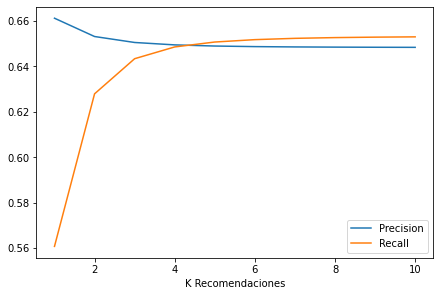

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
xdata = k_list
ydata_prec = precisions_list
ax.plot(xdata, ydata_prec, label='Precision')

y_data_rec = recalls_list
ax.plot(xdata, y_data_rec, label='Recall')
ax.set_xlabel('K Recomendaciones')
ax.legend()

plt.show()

Según lo observado en el gráfico, el mejor trade-off entre *Precision* y *Recall* lo obtenemos con valores de *K* Recomendaciones entre 4 y 5. De todos modos, la diferencia entre ambas para valores de *K* mayores es mínima.

## *Conclusiones*

A la información obtenida anteriormente respecto de la Precision y el Recall, podemos agregar un análisis sobre el *RMSE*

In [ ]:
diccionario_errores = {

        'BaselineOnly (Benchmark)': {
                        'RMSE': rmse_benchmark
                      },
        'SVD': {
                 'RMSE': rmse_svd
               }
}

df_matriz_errores = pd.DataFrame(data=diccionario_errores)
df_matriz_errores

,BaselineOnly (Benchmark),SVD
RMSE,0.508342,0.510251


Como se observa, la métrica elegida para evaluar los errores del modelo fue *RMSE*. Tanto el algoritmo de Benchmark como el SVD utilizado como algoritmo final tuvieron valores similares de error. 

Uno de los desafíos que encontré a medida que avanzaba con la creación del Sistema de Recomendación y el tratamiento de los datos fue la necesidad de optimizar el uso de la memoria. Para ello fue necesario ir ajustando los tipos de datos utilizados, tanto en DataFrames auxiliares como en la Matriz de Ratings final, particularmente cuando comencé a trabajar con el lote de Reviews completo. 
Una consecuencia no esperada relativa a lo mencionado fue que las predicciones de los Ratings fue diferente dependiendo del tipo de dato usado. Inicialmente manejaba los IDs de usuarios como Strings y obtuve ciertas predicciones; luego debí transformarlos en enteros y obtuve otras predicciones. Debido a esto, fue necesario revisar de manera minuciosa que todos los tipos de datos utilizados para la elaboración y posterior predicción fueran coherentes y estuviesen alineados para poder obtener los valores adecuados.